In [1]:
# The cells in this notebook run each step in the HydroFlow workflow
# This workflow was developed to function from within the designated SnowModel
# folder for each domain.

# Import all of the python packages used in this workflow.
import scipy
import numpy as np
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from datetime import date, datetime
from datetime import timedelta  
import json
from xgrads import open_CtlDataset
import os
import glob
import requests
import matplotlib.pyplot as plt


# Choose a domain
domain = 'YUKO'

# huc label
huc = 'HUC4 1904'

# Path to the SnowModel folder
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
#SMpath = '/scratch/Nina/NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'

# path to files
wsd_ctl = SMpath+'/watershed/watershed.ctl'
wsdlistpath = '/nfs/attic/dfh/2020_NPRB/data/hf/'+domain+'/watersheds.csv'

# results path
resultpath = '/nfs/attic/dfh/2020_NPRB/data/results/'+domain+'/'

# results figures path
figpath = '/nfs/attic/dfh/2020_NPRB/data/results/figures/'

#path to coast mask
coastmaskpath = '/nfs/attic/dfh/2020_NPRB/data/hf/'+domain+'/coast_mask.nc'
coast = xr.open_dataset(coastmaskpath)
coast = coast.rename({'lat':'y','lon':'x'})


#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()
    
# Define nx and ny for this domain to be used later
nx = domains[domain]['ncols']
ny = domains[domain]['nrows']
clsz = domains[domain]['cellsize']
xll = domains[domain]['xll']
yll = domains[domain]['yll']

wys = list(range(1991,2001))

# dates
hist = pd.date_range(start ='10-01-1990', end ='09-30-2020', freq ='1D')

In [2]:
# open watershed data
wd = open_CtlDataset(wsd_ctl)
wd = wd.isel(lev=0,time=0).rio.write_crs(domains[domain]['mod_proj'], inplace=True)
wd = wd.rename({'lat':'y','lon':'x'})
wd

<xarray.Dataset>
Dimensions:      (y: 1228, x: 949)
Coordinates:
    time         datetime64[ns] 2011-10-01
    lev          float64 1.0
  * y            (y) float32 4.17e+05 4.18e+05 4.19e+05 ... 1.643e+06 1.644e+06
  * x            (x) float32 -7.71e+05 -7.7e+05 -7.69e+05 ... 1.76e+05 1.77e+05
    spatial_ref  int64 0
Data variables:
    dir          (y, x) float32 dask.array<chunksize=(1228, 949), meta=np.ndarray>
    wshed        (y, x) float32 dask.array<chunksize=(1228, 949), meta=np.ndarray>
    order        (y, x) float32 dask.array<chunksize=(1228, 949), meta=np.ndarray>
Attributes:
    comment:  flow direction
    storage:  0
    title:    
    undef:    -9999.0
    pdef:     None

In [3]:
# open list of watersheds to include
wsd_list = pd.read_csv(wsdlistpath,index_col=0)
wsdlist=wsd_list.wd.tolist()

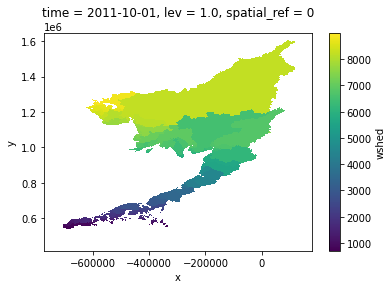

In [4]:
wd.wshed.where(wd.wshed.isin(wsdlist)).plot()

In [5]:
ar = wd.wshed.where(coast.maskq==1).values
len(ar[~np.isnan(ar)]),len(np.unique(ar[~np.isnan(ar)]))

(3215, 3215)

In [ ]:
wsheds = []
wsdsize = []
coastlats = []
coastlons = []
coastys = []
coastxs = []
coastyidxs = []
coastxidxs = []

for i in range(len(wd.y)):
    for j in range(len(wd.x)):
        if coast.maskq.isel(y=i,x=j) == 1:        

            wsd = int(wd.wshed.isel(y=i,x=j).values)
            wsheds.append(wsd)
            wsdsize.append(int(wd.wshed.where(wd.wshed == wsd).count().values)*int(clsz)*int(clsz)/1e6)
            #coastlats.append(int(wd_latlon.y.isel(y=i).values))
            #coastlons.append(int(wd_latlon.x.isel(x=j).values))
            coastys.append(int(wd.y.isel(y=i).values))
            coastxs.append(int(wd.x.isel(x=j).values))
            coastyidxs.append(i)
            coastxidxs.append(j)
        else:
            continue


In [ ]:
np.arange(0,len(wsheds))

In [ ]:
df = pd.DataFrame({
    'cell_id':np.arange(0,len(wsheds)),
    'wshed':wsheds,
    'area_km2':wsdsize,
    'epsg3338_X':coastxs,
    'epsg3338_Y':coastys,
    'grid_X':coastxidxs,
    'grid_Y':coastyidxs})
df

In [ ]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.epsg3338_X, df.epsg3338_Y), crs=domains[domain]['mod_proj']
)
gdf=gdf.to_crs("EPSG:4326")
gdf

In [ ]:
df['lon'] = gdf.geometry.x
df['lat'] = gdf.geometry.y
df = df.drop(['geometry'], axis=1)
df

In [ ]:
df.to_csv(resultpath+domain+'_coast_cells_ll.csv', index = False)

In [ ]:
df=pd.read_csv(resultpath+domain+'_coast_cells_ll.csv')
df

In [ ]:
# build readme for .csv
readmepath = resultpath+domain+'_README.txt'
    
lines = ['This file provides an overview of the output files contained in this directory for the '+domain+' domain.',\
         '1. '+domain+'_coast_cells_ll.csv',\
         '	This file contains an overview of the grid cells in the '+domain+'_disc_wy1991-2020.nc file that are associated with coastal discharge. All coordinates correspond to the lower left corner of grid cells.',\
         '	The following variables are included:',\
         '		cell_id: Coastal grid cells are numbered 0-N.',\
         '		wshed: The watershed ID assigned in HydroFlow.',\
         '		area_km2: The area of the watershed drained by the coastal grid cell in kilometers.',\
         '		epsg3338_X: The projected x coordinate of the coastal grid cell in epsg:3338.',\
         '		epsg3338_Y: The projected y coordinate of the coastal grid cell in epsg:3338.',\
         '		grid_X: The x index of the coastal grid cell. Note - indexing starts at 0.',\
         '		grid_Y: The y index of the coastal grid cell. Note - indexing starts at 0.',\
         '		lon: The longitude of the coastal grid cell in epsg:4326.',\
         '		lat: The latitude of the coastal grid cell in epsg:4326.',\
         '2. '+domain+'_disc_wy1991-2020.nc',\
         ' 	This file contains daily discharge for each grid cell in the '+domain+' domain for water years 1991-2020. A mask indicating coastal grid cells is also included.',\
         '3. '+domain+'_disc_coast_wy1991-2020.nc',\
         ' 	This file contains daily discharge for each coastal grid cell in the '+domain+' domain for water years 1991-2020.',\
         '4. '+domain+'_prec_wy1991-2020.nc',\
         ' 	This file contains daily precipitation for each grid cell in the '+domain+' domain for water years 1991-2020.',\
         '5. '+domain+'_etx_wy1991-2020.nc',\
         ' 	This file contains daily evapotranspiration for each grid cell in the '+domain+' domain for water years 1991-2020.',\
         '6. '+domain+'_ssub_wy1991-2020.nc',\
         ' 	This file contains daily sublimation for each grid cell in the '+domain+' domain for water years 1991-2020.',\
         '7. '+domain+'_swed_wy1991-2020.nc',\
         ' 	This file contains daily snow water equivalent depths for each grid cell in the '+domain+' domain for water years 1991-2020.',\
         '8. '+domain+'_tair_wy1991-2020.nc',\
         ' 	This file contains daily air temperature for each grid cell in the '+domain+' domain for water years 1991-2020.',\
         '9. '+domain+'_annual_summary_wy1991-2020.csv',\
         ' 	This file contains annual values of the following variables across '+huc+' for water years 1991-2020:',\
         '		annual_Qcoast_m3: Annual coastal runoff in cubic meters.',\
         '		annual_etx_m3:  Annual evapotranspiration in cubic meters.',\
         '		annual_prec_m3: Annual precipitation in cubic meters.',\
         '		annual_ssub_m3: Annual sublimation in cubic meters.',\
         '		annual_max_swed_m3: Annual maximum snow water equivalent in cubic meters.',\
         '		annual_av_tair_C: Annual average temperature in degrees Celsius.',\
         '10. '+domain+'_monthly_climatology_wy1991-2020.csv',\
         ' 	This file contains monthly climatologies of the following variables across '+huc+' for water years 1991-2020:',\
         '		disc_coast_m3: Average monthly coastal discharge in cubic meters.',\
         '		et_m3: Average monthly evapotranspiration in cubic meters.',\
         '		prec_m3: Average monthly precipitation in cubic meters.',\
         '		sub_m3: Average monthly sublimation in cubic meters.',\
         '		swe_max_m3: Average maximum monthly snow water equivalent in cubic meters.',\
         '		tair_av_C: Average monthly temperature in degrees Celsius.',\
         'This directory also contains analagous files for the future time period including water years 2071-2100.']         


with open(readmepath, 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')
f.close() 

# gridded variables

In [ ]:
# open coast data
coast = xr.open_dataset(coastmaskpath)
# open watershed data
wd = open_CtlDataset(wsd_ctl)
# open list of watersheds to include
wsd_list = pd.read_csv(wsdlistpath,index_col=0)
wsdlist=wsd_list.wd.tolist()
# open indexing df
df=pd.read_csv(resultpath+domain+'_coast_cells_ll.csv')

## disc

In [ ]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_hist/disc*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Qs = []
Ts = []
anQ = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    q = open_CtlDataset(file)
    # sum slow and fast flow
    qtot = q.fast + q.slow
    # select second year
    qtotslice = qtot.isel(lev=0).sel(time=slice(file[-13:-9]+'-10-01',file[-8:-4]+'-09-30'))
    # store water year
    wy.append(int(file[-8:-4]))
    # mask to HUC4
    qtotslice = qtotslice.where((qtotslice>=0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Qs.append(qtotslice.values)
    # Q at coast cells
    qtotmask = qtotslice.where(coast.maskq==1)
    # store dates
    Ts.append(qtotmask.time.values)
    # annual Q
    anQ.append(qtotmask.sum(dim=['time','lat','lon']).values.tolist())
# convert lists to arrays
qclims = np.concatenate(Qs)
tclims = np.concatenate(Ts)

In [ ]:
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    disc=(["time","y", "x"],
          qclims,
          {'units':'cubic meters per day',
           'long_name':'Daily discharge',
           'standard_name':'runoff_flux',
           'standard_units':'kg m-2 s-1'}),
),
coords=dict(
    time=hist,
    y=q.lat.values,
    x=q.lon.values,
),)

# add dataset of origin to attribute list
ds['coast_mask']=(('y','x'),coast.maskq.values)  
ds.attrs.update({
    'title':'Freshwater Discharge from 4-digit HUC 1904 into the Bering Sea',
    'summary':'Coastal FWD was modeled using a suite of physically based, spatially distributed weather, energy-balance snow/ice melt, soil water balance, and runoff routing models at a high resolution (2.5 km horizontal grid; daily time step). Discharge was modeled across the 1904 HUC4 subregion.',
    'keywords':'DISCHARGE/FLOW, ALASKA, YOUKON, BERING SEA, HUC4 1904',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner',
    'coast_mask':'Values of 1 indicate coastal pixels.'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_disc_wy1991-2020.nc')

In [2]:
ds = xr.open_dataset(resultpath+domain+'_disc_wy1991-2020.nc')
ds

<xarray.Dataset>
Dimensions:      (time: 10958, y: 527, x: 863)
Coordinates:
  * time         (time) datetime64[ns] 1990-10-01 1990-10-02 ... 2020-09-30
  * y            (y) float32 9.85e+05 9.875e+05 9.9e+05 ... 2.298e+06 2.3e+06
  * x            (x) float32 -7.275e+05 -7.25e+05 ... 1.425e+06 1.428e+06
Data variables:
    disc         (time, y, x) float32 ...
    coast_mask   (y, x) float64 ...
    spatial_ref  int64 ...
Attributes:
    title:          Freshwater Discharge from 4-digit HUC 1904 into the Berin...
    summary:        Coastal FWD was modeled using a suite of physically based...
    keywords:       DISCHARGE/FLOW, ALASKA, YOUKON, BERING SEA, HUC4 1904
    date_created:   Dataset created March 2024
    creator_name:   Christina Marie Aragon
    creator_email:  aragonch@oregonstate.edu
    institution:    Oregon State University
    note:           x y coordinates correspond to lower left corner
    coast_mask:     Values of 1 indicate coastal pixels.

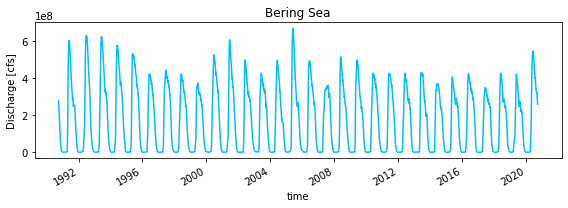

In [3]:
# coastal discharge
coastalQ = ds.disc.sum(dim=['x','y'])
# convert units
coastQft3 = coastalQ*35.3147/(24*60*60)
fig, ax = plt.subplots(1,figsize=[8,3])
coastQft3.plot(c='#00bfff',ax=ax)
ax.set_ylabel('Discharge [cfs]')
plt.title('Bering Sea')
plt.tight_layout()
fig.savefig(figpath+domain+'coastalQ_wy1991-2020.png',dpi=300)

In [ ]:
# save out annual Q data
dfq = pd.DataFrame({'water_year':wy,'annual_Qcoast_m3':anQ})
dfq.to_csv(resultpath+'temp/'+domain+'_annual_disc_coast_wy1991-2020.csv')

In [ ]:
# coastal disc .nc
#empty array to store data
ar = np.empty([len(df),len(ds.time)])

for i in range(len(df)):
    # select disc at each of the coastal pixels
    ar[i,:]=ds.disc.isel(x=df.grid_X[i],y=df.grid_Y[i]).values
    
# coastal grid
# build xarray data array to save out
qcoastclim = xr.DataArray(
    ar,
    dims=['id','time'],
    coords={
        'id':df.cell_id.values,
        'lat': ('id',df.lat.values),
        'lon': ('id',df.lon.values),
        'time':hist,},
    attrs={'units':'cubic meters per day',
           'long_name':'Daily discharge',
           'standard_name':'runoff_flux',
           'standard_units':'kg m-2 s-1'}
)
# convert to dataset
dsc=qcoastclim.to_dataset(name = 'disc_coast') 
# add dataset of origin to attribute list
dsc.attrs.update({
    'title':'Coastal Freshwater Discharge from 4-digit HUC 1904 into the Bering Sea',
    'summary':'Coastal FWD was modeled using a suite of physically based, spatially distributed weather, energy-balance snow/ice melt, soil water balance, and runoff routing models at a high resolution (2.5 km horizontal grid; daily time step). Discharge was modeled across the 1904 HUC4 subregion.',
    'keywords':'DISCHARGE/FLOW, ALASKA, YOUKON, BERING SEA, HUC4 1904',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'projection':'epsg:4326',
    'note':'lat lon coordinates correspond to lower left corner'
})
# save to .nc file
dsc.to_netcdf(resultpath+domain+'_disc_coast_wy1991-2020.nc')

## prec

In [ ]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_hist/prec*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Ds = []
Ts = []
anD = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    data = open_CtlDataset(file)
    # select second year
    dataslice = data.prec.sel(time=slice(file[-13:-9]+'-10-01',file[-8:-4]+'-09-30'))
    # store water year
    wy.append(int(file[-8:-4]))
    # mask to HUC4
    maskslice = dataslice.where((dataslice>=0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Ds.append(maskslice.values)
    # store dates
    Ts.append(dataslice.time.values)
    # annual P [cubic m]
    anD.append(maskslice.sum(dim=['time','lat','lon']).values.tolist()*int(clsz)*int(clsz))
# convert lists to arrays
dataclims = np.concatenate(Ds)
tclims = np.concatenate(Ts)

In [ ]:
# standard name and units from https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    prec=(["time","y", "x"],
          dataclims,
          {'units':'meters',
           'long_name':'Daily precipitation',
           'standard_name':'precipitation_amount',
           'standard_units':'kg m-2'}),
),
coords=dict(
    time=hist,
    y=data.lat.values,
    x=data.lon.values,
),)

# add dataset of origin to attribute list
ds.attrs.update({
    'title':'Daily Precipitation Across 4-digit HUC 1904',
    'summary':'Precipitation was modeled using a suite of physically based, spatially distributed weather and energy-balance snow/ice melt models at a high resolution (2.5 km horizontal grid; daily time step). Precipitation was modeled across the 1904 HUC4 subregion.',
    'keywords':'PRECIPITATION, ALASKA, HUC4 1904',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_prec_wy1991-2020.nc')

In [ ]:
# save out annual P data
dfdata = pd.DataFrame({'water_year':wy,'annual_prec_m3':anD})
dfdata.to_csv(resultpath+'temp/'+domain+'_annual_prec_wy1991-2020.csv')

In [ ]:
ds = xr.open_dataset(resultpath+domain+'_prec_wy1991-2020.nc')
plotdata = ds.prec.mean(dim=['y','x'])
# save fig
fig, ax = plt.subplots(1,figsize=[8,3])
plotdata.plot(c='#00bfff',ax=ax)
ax.set_ylabel('Precipitation [m]')
plt.title(huc)
plt.tight_layout()
fig.savefig(figpath+domain+'_P_wy1991-2020.png',dpi=300)

## ET

In [ ]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_hist/etx*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Ds = []
Ts = []
anD = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    data = open_CtlDataset(file)
    # select second year
    dataslice = data.etx.sel(time=slice(file[-13:-9]+'-10-01',file[-8:-4]+'-09-30'))
    # store water year
    wy.append(int(file[-8:-4]))
    # mask to HUC4
    maskslice = dataslice.where((dataslice>=0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Ds.append(maskslice.values)
    # store dates
    Ts.append(dataslice.time.values)
    # annual P [cubic m]
    anD.append(maskslice.sum(dim=['time','lat','lon']).values.tolist()*int(clsz)*int(clsz))
# convert lists to arrays
dataclims = np.concatenate(Ds)
tclims = np.concatenate(Ts)

In [ ]:
# standard name and units from https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    et=(["time","y", "x"],
          dataclims,
          {'units':'meters',
           'long_name':'Daily evapotranspiration',
           'standard_name':'water_evapotranspiration_amount',
           'standard_units':'kg m-2'}),
),
coords=dict(
    time=hist,
    y=data.lat.values,
    x=data.lon.values,
),)

# add dataset of origin to attribute list
ds.attrs.update({
    'title':'Daily Evapotranspiration Across 4-digit HUC 1904',
    'summary':'Evapotranspiration was modeled using a suite of physically based, spatially distributed weather and energy-balance snow/ice melt models at a high resolution (2.5 km horizontal grid; daily time step). Evapotranspiration was modeled across the 1904 HUC4 subregion.',
    'keywords':'EVAPOTRANSPIRATION, ALASKA, HUC4 1904',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_etx_wy1991-2020.nc')

In [ ]:
# save out annual ET data
dfdata = pd.DataFrame({'water_year':wy,'annual_etx_m3':anD})
dfdata.to_csv(resultpath+'temp/'+domain+'_annual_etx_wy1991-2020.csv')

In [ ]:
ds = xr.open_dataset(resultpath+domain+'_etx_wy1991-2020.nc')
plotdata = ds.et.mean(dim=['y','x'])
# save fig
fig, ax = plt.subplots(1,figsize=[8,3])
plotdata.plot(c='#00cc66',ax=ax)
ax.set_ylabel('Evapotranspiration [m]')
plt.title(huc)
plt.tight_layout()
fig.savefig(figpath+domain+'_ET_wy1991-2020.png',dpi=300)

## SUB

In [ ]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_hist/ssub*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Ds = []
Ts = []
anD = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    data = open_CtlDataset(file)
    # select second year
    dataslice = data.ssub.sel(time=slice(file[-13:-9]+'-10-01',file[-8:-4]+'-09-30'))
    # store water year
    wy.append(int(file[-8:-4]))
    # mask to HUC4
    maskslice = dataslice.where((dataslice>=0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Ds.append(maskslice.values)
    # store dates
    Ts.append(dataslice.time.values)
    # annual P [cubic m]
    anD.append(maskslice.sum(dim=['time','lat','lon']).values.tolist()*int(clsz)*int(clsz))
# convert lists to arrays
dataclims = np.concatenate(Ds)
tclims = np.concatenate(Ts)

In [ ]:
# standard name and units from https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    sub=(["time","y", "x"],
          dataclims,
          {'units':'meters',
           'long_name':'Daily sublimation',
           'standard_name':'surface_snow_sublimation_amount',
           'standard_units':'kg m-2'}),
),
coords=dict(
    time=hist,
    y=data.lat.values,
    x=data.lon.values,
),)

# add dataset of origin to attribute list
ds.attrs.update({
    'title':'Daily Sublimation Across 4-digit HUC 1904',
    'summary':'Sublimation was modeled using a suite of physically based, spatially distributed weather and energy-balance snow/ice melt models at a high resolution (2.5 km horizontal grid; daily time step). Sublimation was modeled across the 1904 HUC4 subregion.',
    'keywords':'SUBLIMATION, ALASKA, HUC4 1904',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_ssub_wy1991-2020.nc')

In [ ]:
# save out annual SUB data
dfdata = pd.DataFrame({'water_year':wy,'annual_ssub_m3':anD})
dfdata.to_csv(resultpath+'temp/'+domain+'_annual_ssub_wy1991-2020.csv')

In [ ]:
ds = xr.open_dataset(resultpath+domain+'_ssub_wy1991-2020.nc')
plotdata = ds.sub.mean(dim=['y','x'])
# save fig
fig, ax = plt.subplots(1,figsize=[8,3])
plotdata.plot(c='#00bfff',ax=ax)
ax.set_ylabel('Sublimation [m]')
plt.title(huc)
plt.tight_layout()
fig.savefig(figpath+domain+'_SUB_wy1991-2020.png',dpi=300)

## SWE

In [ ]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_hist/swed*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Ds = []
Ts = []
anD = []
endD = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    data = open_CtlDataset(file)
    # select second year
    dataslice = data.swed.sel(time=slice(file[-13:-9]+'-10-01',file[-8:-4]+'-09-30'))
    # store water year
    wy.append(int(file[-8:-4]))
    # mask to HUC4
    maskslice = dataslice.where((dataslice>=0)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Ds.append(maskslice.values)
    # store dates
    Ts.append(dataslice.time.values)
    # daily swe sum
    swesum = maskslice.sum(dim=['lat','lon'])
    # date of max swe
    mxtime = swesum.time.where(swesum==swesum.max(),drop=True).values
    # annual max swe [m]
    anD.append(maskslice.sel(time = mxtime).sum().values*int(clsz)*int(clsz))
    # swe left on last day
    endD.append(maskslice.isel(time=-1).sum().values*int(clsz)*int(clsz))
# convert lists to arrays
dataclims = np.concatenate(Ds)
tclims = np.concatenate(Ts)

In [ ]:
# standard name and units from https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    swed=(["time","y", "x"],
          dataclims,
          {'units':'meters',
           'long_name':'Daily snow water equivalent',
           'standard_name':'lwe_thickness_of_surface_snow_amount',
           'standard_units':'kg m-2'}),
),
coords=dict(
    time=hist,
    y=data.lat.values,
    x=data.lon.values,
),)

# add dataset of origin to attribute list
ds.attrs.update({
    'title':'Daily Snow Water Equivalent Across 4-digit HUC 1904',
    'summary':'Snow Water Equivalent was modeled using a suite of physically based, spatially distributed weather and energy-balance snow/ice melt models at a high resolution (2.5 km horizontal grid; daily time step). Snow Water Equivalent was modeled across the 1904 HUC4 subregion.',
    'keywords':'SNOW WATER EQUIVALENT, SWE, ALASKA, HUC4 1904',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_swed_wy1991-2020.nc')

In [ ]:
# save out annual SWE data
dfdata = pd.DataFrame({'water_year':wy,'annual_max_swed_m3':anD,'endofwy_swed_m3':endD})
dfdata.to_csv(resultpath+'temp/'+domain+'_annual_swed_wy1991-2020.csv')

In [ ]:
ds = xr.open_dataset(resultpath+domain+'_swed_wy1991-2020.nc')
plotdata = ds.swed.mean(dim=['y','x'])
# save fig
fig, ax = plt.subplots(1,figsize=[8,3])
plotdata.plot(c='#00bfff',ax=ax)
ax.set_ylabel('SWE [m]')
plt.title(huc)
plt.tight_layout()
fig.savefig(figpath+domain+'_SWE_wy1991-2020.png',dpi=300)

## Temp

In [ ]:
# path to 2-year .ctl files 
outputpath = SMpath+'outputs_hist/tair*.ctl'
list_of_files = sorted( filter( os.path.isfile,glob.glob(outputpath) ) )

# empty arrays to store variables
Ds = []
Ts = []
avD = []
mnD = []
mxD = []
wy = []
for file in list_of_files:
    print(file)
    # open .gdat
    data = open_CtlDataset(file)
    # select second year
    dataslice = data.tair.sel(time=slice(file[-13:-9]+'-10-01',file[-8:-4]+'-09-30'))
    # store water year
    wy.append(int(file[-8:-4]))
    # mask to HUC4
    maskslice = dataslice.where((dataslice>-9999)&(wd.wshed.isel(lev=0,time=0).isin(wsdlist)))
    # store second year 
    Ds.append(maskslice.values)
    # store dates
    Ts.append(dataslice.time.values)
    # daily temp across domain
    dailyT = maskslice.mean(dim=['lat','lon'])
    # annual mean temp
    avD.append(dailyT.mean().values)
    # annual min temp
    mnD.append(dailyT.min().values)
    # annual max temp
    mxD.append(dailyT.max().values)
# convert lists to arrays
dataclims = np.concatenate(Ds)
tclims = np.concatenate(Ts)

In [ ]:
# standard name and units from https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
# write out .nc
ds = xr.Dataset(
data_vars=dict(
    tair=(["time","y", "x"],
          dataclims,
          {'units':'C',
           'long_name':'Daily air temperature',
           'standard_name':'air_temperature',
           'standard_units':'K'}),
),
coords=dict(
    time=hist,
    y=data.lat.values,
    x=data.lon.values,
),)

# add dataset of origin to attribute list
ds.attrs.update({
    'title':'Daily Air Temperature Across 4-digit HUC 1904',
    'summary':'Air temperature was modeled using a suite of physically based, spatially distributed weather and energy-balance snow/ice melt models at a high resolution (2.5 km horizontal grid; daily time step). Air temperature was modeled across the 1904 HUC4 subregion.',
    'keywords':'AIR TEMPERATURE, ALASKA, HUC4 1904',
    'date_created':'Dataset created March 2024',
    'creator_name':'Christina Marie Aragon',
    'creator_email':'aragonch@oregonstate.edu',
    'institution':'Oregon State University',
    'note':'x y coordinates correspond to lower left corner'
})
ds.rio.write_crs(domains[domain]['mod_proj'], inplace=True)
ds.to_netcdf(resultpath+domain+'_tair_wy1991-2020.nc')

In [ ]:
# save out annual SWE data
dfdata = pd.DataFrame({'water_year':wy,'annual_av_tair_C':avD})
dfdata.to_csv(resultpath+'temp/'+domain+'_annual_tair_wy1991-2020.csv')

In [ ]:
ds = xr.open_dataset(resultpath+domain+'_tair_wy1991-2020.nc')
plotdata = ds.tair.mean(dim=['y','x'])
# save fig
fig, ax = plt.subplots(1,figsize=[8,3])
plotdata.plot(c='r',ax=ax)
ax.set_ylabel('Temperature [C]')
plt.title(huc)
plt.tight_layout()
fig.savefig(figpath+domain+'_T_wy1991-2020.png',dpi=300)

# Annual summary

In [ ]:
df1 = pd.read_csv(resultpath+'temp/'+domain+'_annual_disc_coast_wy1991-2020.csv',index_col=0)
df2 = pd.read_csv(resultpath+'temp/'+domain+'_annual_etx_wy1991-2020.csv')
df2 = df2.drop(columns=['Unnamed: 0','water_year'])
df3 = pd.read_csv(resultpath+'temp/'+domain+'_annual_prec_wy1991-2020.csv')
df3 = df3.drop(columns=['Unnamed: 0','water_year'])
df4 = pd.read_csv(resultpath+'temp/'+domain+'_annual_ssub_wy1991-2020.csv')
df4 = df4.drop(columns=['Unnamed: 0','water_year'])
df5 = pd.read_csv(resultpath+'temp/'+domain+'_annual_swed_wy1991-2020.csv')
df5 = df5.drop(columns=['Unnamed: 0','water_year','endofwy_swed_m3'])
df6 = pd.read_csv(resultpath+'temp/'+domain+'_annual_tair_wy1991-2020.csv')
df6 = df6.drop(columns=['Unnamed: 0','water_year'])

In [ ]:
dffinal = pd.concat([df1, df2,df3,df4,df5,df6], axis=1)
dffinal

In [ ]:
dffinal.annual_av_tair_C = [round(val,2) for val in dffinal.annual_av_tair_C]
dffinal

In [ ]:
dffinal.to_csv(resultpath+domain+'_annual_summary_wy1991-2020.csv')

# monthly climatology

In [ ]:
ds = xr.open_dataset(resultpath+domain+'_disc_coast_wy1991-2020.nc')
group = ds.disc_coast.sum(dim=['id'])
groupm = group.groupby('time.month').mean()
df = pd.DataFrame({'month':groupm.month.values,'disc_coast_m3':[round(val,2) for val in groupm.values]})
ds = xr.open_dataset(resultpath+domain+'_etx_wy1991-2020.nc')
group = ds.et.sum(dim=['x','y'])
groupm = group.groupby('time.month').mean()
groupmvol = groupm.values*int(clsz)*int(clsz)
df['et_m3']=[round(val,2) for val in groupmvol]
ds = xr.open_dataset(resultpath+domain+'_prec_wy1991-2020.nc')
group = ds.prec.sum(dim=['x','y'])
groupm = group.groupby('time.month').mean()
groupmvol = groupm.values*int(clsz)*int(clsz)
df['prec_m3']=[round(val,2) for val in groupmvol]
ds = xr.open_dataset(resultpath+domain+'_ssub_wy1991-2020.nc')
group = ds.sub.sum(dim=['x','y'])
groupm = group.groupby('time.month').mean()
groupmvol = groupm.values*int(clsz)*int(clsz)
df['sub_m3']=[round(val,2) for val in groupmvol]
ds = xr.open_dataset(resultpath+domain+'_swed_wy1991-2020.nc')
group = ds.swed.sum(dim=['x','y'])
groupm = group.groupby('time.month').max()
groupmvol = groupm.values*int(clsz)*int(clsz)
df['swe_max_m3']=[round(val,2) for val in groupmvol]
ds = xr.open_dataset(resultpath+domain+'_tair_wy1991-2020.nc')
group = ds.tair.mean(dim=['x','y'])
groupm = group.groupby('time.month').mean()
df['tair_av_C']=[round(val,2) for val in groupm.values]
df.to_csv(resultpath+domain+'_monthly_climatology_wy1991-2020.csv')

In [ ]:
df